## Preparation

### Download the optimization support library package

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.9 MB/s eta 0:00:00


### Connect to Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Import Libraries

In [3]:
# Library to support working with data
import numpy as np
import pandas as pd

# Graphing support library
import matplotlib.pyplot as plt

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Library to support building Temporal Convolutional Attention Networks models
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Layer, RepeatVector, concatenate, Reshape, Input, Concatenate, Permute, Multiply, Add, Activation

# Performance metrics calculation support library
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

# Parameter optimization support library
import optuna

# Support library to ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Support library to load models and data
from keras.utils import custom_object_scope
from tensorflow.keras.models import load_model

## Data preprocessing

### Read data

In [4]:
# Load data
df = pd.read_csv('NTR.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,46.209999,46.990002,45.855000,46.259998,40.076595,1289100
1,2019-01-03,46.000000,46.099998,44.882999,45.049999,39.028339,1158800
2,2019-01-04,45.950001,47.180000,45.880001,47.130001,40.830315,1538500
3,2019-01-07,47.310001,48.110001,46.840000,47.740002,41.358772,954700
4,2019-01-08,48.709999,49.480000,48.520000,49.209999,42.632286,1921800
...,...,...,...,...,...,...,...
1114,2023-06-06,53.000000,57.294998,52.820000,57.220001,57.220001,6397900
1115,2023-06-07,57.610001,59.750000,57.520000,59.340000,59.340000,2925500
1116,2023-06-08,59.400002,60.080002,57.910000,58.939999,58.939999,2828400
1117,2023-06-09,58.959999,59.349998,58.290001,58.790001,58.790001,1686600


### Reset index

In [5]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [6]:
# Select column 'Close'
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

### Data normalization

In [7]:
# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Close))

### Data splitting

In [8]:
# Split the data into train, validation, and test dataset in a ratio of 7:1:2
train_size = int(len(data_scaled) * 0.7)
val_size = int(len(data_scaled) * 0.1)
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

## Model training and testing

In [9]:
# Generating data using the window sliding method
def create_dataset(data, window_size):
    windows, targets = [], []
    for i in range(len(data) - window_size - 1):
        windows.append(data[i : (i + window_size), 0])
        targets.append(data[i + window_size, 0])
    return np.array(windows), np.array(targets)

### Building TCANs model

In [10]:
# Constructing sparse attention layer
class AttentionLayer(Layer):
    def __init__(self, attention_dim):
        super(AttentionLayer, self).__init__()
        self.attention_dim = attention_dim

    def build(self, input_shape):
        self.W1 = Dense(units=self.attention_dim, activation='tanh')
        self.W2 = Dense(units=1, activation='linear')
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        score = self.W2(self.W1(x))
        score = Flatten()(score)
        score = Activation('softmax')(score)
        score = RepeatVector(x.shape[-1])(score)
        score = Permute([2, 1])(score)
        return Multiply()([x, score])

    def compute_output_shape(self, input_shape):
        return input_shape

In [11]:
# Build TCAN model
def build_tcan(window_size, input_dim=1, tcn_filters=64, tcn_kernel_size=2, dropout_rate=0.2, attention_dim=16):
    inputs = Input(shape=(window_size, input_dim))
    x = inputs
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)

    # Additive Attention
    att = AttentionLayer(attention_dim)(x)
    max_pool_att = GlobalMaxPooling1D()(att)
    max_pool_x = GlobalMaxPooling1D()(x)
    x = concatenate([max_pool_att, max_pool_x])

    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    return model

### Learning process with combined parameter optimization

In [12]:
# Initialization of optimization parameters
best_mse = float('inf')
best_model = None
best_window_size = None
best_train_windows = None
best_train_targets = None
best_test_windows = None
best_test_targets = None
best_val_windows = None
best_val_targets = None
best_y_pred = None
best_mape = np.inf
best_rmse = np.inf
best_msle = np.inf

In [13]:
# Define the objective function for Optuna optimization
def objective(trial):
  global best_mse, best_model, best_window_size, best_train_windows
  global best_train_targets, best_test_windows, best_test_targets, best_val_windows
  global best_val_targets, best_y_pred, best_mape, best_rmse, best_msle

  # Define the search space for hyperparameters
  window_size = trial.suggest_int("window_size", 10, 100)
  tcn_filters = trial.suggest_int("tcn_filters", 32, 128)
  tcn_kernel_size = trial.suggest_int("tcn_kernel_size", 2, 5)
  dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
  attention_dim = trial.suggest_int("attention_dim", 8, 32)

  # Build the TCAN model with the suggested hyperparameters
  model = build_tcan(window_size,
                     tcn_filters = tcn_filters,
                     tcn_kernel_size = tcn_kernel_size,
                     dropout_rate = dropout_rate,
                     attention_dim = attention_dim)

  train_windows, train_targets = create_dataset(train_data, window_size)
  test_windows, test_targets = create_dataset(test_data, window_size)
  val_windows, val_targets = create_dataset(val_data, window_size)

  # Train the model
  early_stop = EarlyStopping(monitor='val_loss', patience=5)
  model.fit(train_windows, train_targets,
            epochs=50, batch_size=32,
            validation_data=(val_windows, val_targets),
            shuffle=False, callbacks=[early_stop], verbose=0)

  # Testing the model on Test dataset
  y_pred = model.predict(test_windows)

  # Evaluate on MAPE, RMSE, MSLE
  temp_test_targets = test_targets
  temp_test_targets = scaler.inverse_transform(temp_test_targets.reshape(-1, 1))
  y_pred = scaler.inverse_transform(y_pred)

  mse = mean_squared_error(temp_test_targets, y_pred)
  rmse = np.sqrt(mse)
  mape = mean_absolute_percentage_error(temp_test_targets, y_pred)
  msle = mean_squared_log_error(temp_test_targets, y_pred)

  # Save the best model and related information
  if mse < best_mse or best_mse is None:
    best_model = model
    best_window_size = window_size
    best_y_pred = y_pred
    best_train_windows = train_windows
    best_train_targets = train_targets
    best_test_windows = test_windows
    best_test_targets = test_targets
    best_val_windows = val_windows
    best_val_targets = val_targets
    best_rmse = rmse
    best_mape = mape
    best_msle = msle
    best_mse = mse

  return mse

In [14]:
# Define the search space for the hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2023-06-14 05:40:25,916] A new study created in memory with name: no-name-ac814236-1e28-4d3e-a74a-b98a0fb03b90


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 05:40:51,882] Trial 0 finished with value: 5.977848414103208 and parameters: {'window_size': 35, 'tcn_filters': 109, 'tcn_kernel_size': 2, 'dropout_rate': 0.4584062591696495, 'attention_dim': 21}. Best is trial 0 with value: 5.977848414103208.


5/5 [==============================] - 0s 15ms/step


[I 2023-06-14 05:41:34,742] Trial 1 finished with value: 39.449014201971686 and parameters: {'window_size': 94, 'tcn_filters': 124, 'tcn_kernel_size': 5, 'dropout_rate': 0.31651533321774894, 'attention_dim': 28}. Best is trial 0 with value: 5.977848414103208.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 05:41:46,781] Trial 2 finished with value: 6.289587922637213 and parameters: {'window_size': 42, 'tcn_filters': 86, 'tcn_kernel_size': 2, 'dropout_rate': 0.489145845252421, 'attention_dim': 28}. Best is trial 0 with value: 5.977848414103208.


6/6 [==============================] - 0s 16ms/step


[I 2023-06-14 05:41:59,002] Trial 3 finished with value: 26.6565345292925 and parameters: {'window_size': 63, 'tcn_filters': 113, 'tcn_kernel_size': 5, 'dropout_rate': 0.23780275320872485, 'attention_dim': 10}. Best is trial 0 with value: 5.977848414103208.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 05:42:07,601] Trial 4 finished with value: 51.244443769028834 and parameters: {'window_size': 72, 'tcn_filters': 122, 'tcn_kernel_size': 5, 'dropout_rate': 0.21535439429976952, 'attention_dim': 11}. Best is trial 0 with value: 5.977848414103208.


5/5 [==============================] - 0s 5ms/step


[I 2023-06-14 05:42:14,946] Trial 5 finished with value: 33.41053068765105 and parameters: {'window_size': 67, 'tcn_filters': 38, 'tcn_kernel_size': 2, 'dropout_rate': 0.2008897256215192, 'attention_dim': 31}. Best is trial 0 with value: 5.977848414103208.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 05:42:22,257] Trial 6 finished with value: 19.65952147983628 and parameters: {'window_size': 24, 'tcn_filters': 36, 'tcn_kernel_size': 5, 'dropout_rate': 0.4421456793824923, 'attention_dim': 29}. Best is trial 0 with value: 5.977848414103208.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-14 05:42:28,513] Trial 7 finished with value: 21.414539370647304 and parameters: {'window_size': 35, 'tcn_filters': 58, 'tcn_kernel_size': 2, 'dropout_rate': 0.1360002707081398, 'attention_dim': 23}. Best is trial 0 with value: 5.977848414103208.


4/4 [==============================] - 0s 11ms/step


[I 2023-06-14 05:42:50,799] Trial 8 finished with value: 3.3551778786680893 and parameters: {'window_size': 98, 'tcn_filters': 82, 'tcn_kernel_size': 3, 'dropout_rate': 0.46675534534496566, 'attention_dim': 17}. Best is trial 8 with value: 3.3551778786680893.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 05:43:02,863] Trial 9 finished with value: 5.533962516077076 and parameters: {'window_size': 38, 'tcn_filters': 64, 'tcn_kernel_size': 4, 'dropout_rate': 0.3682103397602742, 'attention_dim': 27}. Best is trial 8 with value: 3.3551778786680893.


4/4 [==============================] - 0s 11ms/step


[I 2023-06-14 05:43:25,234] Trial 10 finished with value: 6.420312207420918 and parameters: {'window_size': 98, 'tcn_filters': 95, 'tcn_kernel_size': 3, 'dropout_rate': 0.3848002519053638, 'attention_dim': 15}. Best is trial 8 with value: 3.3551778786680893.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 05:43:31,640] Trial 11 finished with value: 6.639265638838338 and parameters: {'window_size': 12, 'tcn_filters': 67, 'tcn_kernel_size': 4, 'dropout_rate': 0.3744321383511465, 'attention_dim': 16}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 05:43:54,660] Trial 12 finished with value: 3.9200858404413124 and parameters: {'window_size': 81, 'tcn_filters': 69, 'tcn_kernel_size': 4, 'dropout_rate': 0.40613564883923875, 'attention_dim': 24}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 05:44:00,280] Trial 13 finished with value: 11.740019206342607 and parameters: {'window_size': 78, 'tcn_filters': 78, 'tcn_kernel_size': 3, 'dropout_rate': 0.49775974937563766, 'attention_dim': 17}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 05:44:22,643] Trial 14 finished with value: 29.813813059530876 and parameters: {'window_size': 85, 'tcn_filters': 55, 'tcn_kernel_size': 4, 'dropout_rate': 0.4300395810073857, 'attention_dim': 24}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 05:44:29,609] Trial 15 finished with value: 15.58528674435788 and parameters: {'window_size': 86, 'tcn_filters': 94, 'tcn_kernel_size': 3, 'dropout_rate': 0.42513273000278884, 'attention_dim': 19}. Best is trial 8 with value: 3.3551778786680893.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 05:44:52,515] Trial 16 finished with value: 5.977690277301115 and parameters: {'window_size': 57, 'tcn_filters': 78, 'tcn_kernel_size': 3, 'dropout_rate': 0.32371776050891815, 'attention_dim': 13}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 05:45:01,668] Trial 17 finished with value: 10.49412460549681 and parameters: {'window_size': 88, 'tcn_filters': 72, 'tcn_kernel_size': 4, 'dropout_rate': 0.3965757160620859, 'attention_dim': 24}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 5ms/step


[I 2023-06-14 05:45:24,543] Trial 18 finished with value: 18.11253060173657 and parameters: {'window_size': 77, 'tcn_filters': 48, 'tcn_kernel_size': 4, 'dropout_rate': 0.46719024751358623, 'attention_dim': 20}. Best is trial 8 with value: 3.3551778786680893.


4/4 [==============================] - 0s 10ms/step


[I 2023-06-14 05:45:33,124] Trial 19 finished with value: 11.642310146895504 and parameters: {'window_size': 99, 'tcn_filters': 91, 'tcn_kernel_size': 3, 'dropout_rate': 0.33950720102684095, 'attention_dim': 22}. Best is trial 8 with value: 3.3551778786680893.


6/6 [==============================] - 0s 12ms/step


[I 2023-06-14 05:45:46,420] Trial 20 finished with value: 5.976439628152898 and parameters: {'window_size': 51, 'tcn_filters': 102, 'tcn_kernel_size': 4, 'dropout_rate': 0.42034742973110323, 'attention_dim': 26}. Best is trial 8 with value: 3.3551778786680893.


6/6 [==============================] - 0s 8ms/step


[I 2023-06-14 05:45:58,824] Trial 21 finished with value: 6.366858229904952 and parameters: {'window_size': 51, 'tcn_filters': 65, 'tcn_kernel_size': 4, 'dropout_rate': 0.36223277092812145, 'attention_dim': 26}. Best is trial 8 with value: 3.3551778786680893.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 05:46:06,637] Trial 22 finished with value: 5.954153705099526 and parameters: {'window_size': 24, 'tcn_filters': 51, 'tcn_kernel_size': 4, 'dropout_rate': 0.40038504901846605, 'attention_dim': 32}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 05:46:12,742] Trial 23 finished with value: 22.193624119529343 and parameters: {'window_size': 92, 'tcn_filters': 62, 'tcn_kernel_size': 3, 'dropout_rate': 0.36030265164449515, 'attention_dim': 18}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 05:46:25,714] Trial 24 finished with value: 6.487853617168657 and parameters: {'window_size': 80, 'tcn_filters': 74, 'tcn_kernel_size': 4, 'dropout_rate': 0.4615775956319494, 'attention_dim': 25}. Best is trial 8 with value: 3.3551778786680893.


6/6 [==============================] - 0s 4ms/step


[I 2023-06-14 05:46:32,032] Trial 25 finished with value: 11.68941283509383 and parameters: {'window_size': 37, 'tcn_filters': 47, 'tcn_kernel_size': 3, 'dropout_rate': 0.28069600048827165, 'attention_dim': 8}. Best is trial 8 with value: 3.3551778786680893.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 05:46:45,708] Trial 26 finished with value: 4.426116694840368 and parameters: {'window_size': 59, 'tcn_filters': 81, 'tcn_kernel_size': 4, 'dropout_rate': 0.40188518415304175, 'attention_dim': 21}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 05:46:57,812] Trial 27 finished with value: 5.758472924695907 and parameters: {'window_size': 68, 'tcn_filters': 87, 'tcn_kernel_size': 5, 'dropout_rate': 0.4123578538826384, 'attention_dim': 14}. Best is trial 8 with value: 3.3551778786680893.


6/6 [==============================] - 0s 6ms/step


[I 2023-06-14 05:47:11,884] Trial 28 finished with value: 45.22249965828368 and parameters: {'window_size': 59, 'tcn_filters': 82, 'tcn_kernel_size': 3, 'dropout_rate': 0.4453831669319955, 'attention_dim': 21}. Best is trial 8 with value: 3.3551778786680893.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 05:47:24,883] Trial 29 finished with value: 15.369164351328978 and parameters: {'window_size': 47, 'tcn_filters': 109, 'tcn_kernel_size': 2, 'dropout_rate': 0.4516492654947707, 'attention_dim': 20}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 14ms/step


[I 2023-06-14 05:47:47,382] Trial 30 finished with value: 5.6036824858810395 and parameters: {'window_size': 75, 'tcn_filters': 102, 'tcn_kernel_size': 4, 'dropout_rate': 0.4767400972394841, 'attention_dim': 22}. Best is trial 8 with value: 3.3551778786680893.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 05:47:59,755] Trial 31 finished with value: 8.319207594172685 and parameters: {'window_size': 29, 'tcn_filters': 70, 'tcn_kernel_size': 4, 'dropout_rate': 0.3952368401397096, 'attention_dim': 27}. Best is trial 8 with value: 3.3551778786680893.


6/6 [==============================] - 0s 5ms/step


[I 2023-06-14 05:48:11,915] Trial 32 finished with value: 5.126333776254598 and parameters: {'window_size': 44, 'tcn_filters': 61, 'tcn_kernel_size': 4, 'dropout_rate': 0.35389716503951946, 'attention_dim': 30}. Best is trial 8 with value: 3.3551778786680893.


6/6 [==============================] - 0s 7ms/step


[I 2023-06-14 05:48:26,394] Trial 33 finished with value: 5.972024031048529 and parameters: {'window_size': 43, 'tcn_filters': 82, 'tcn_kernel_size': 5, 'dropout_rate': 0.42034190675203564, 'attention_dim': 30}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 05:48:48,938] Trial 34 finished with value: 8.076771305517058 and parameters: {'window_size': 95, 'tcn_filters': 75, 'tcn_kernel_size': 4, 'dropout_rate': 0.34195922798362904, 'attention_dim': 18}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 05:49:11,910] Trial 35 finished with value: 3.7134666910295557 and parameters: {'window_size': 83, 'tcn_filters': 87, 'tcn_kernel_size': 5, 'dropout_rate': 0.4805178553283955, 'attention_dim': 22}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 05:49:34,270] Trial 36 finished with value: 3.5040144372210844 and parameters: {'window_size': 83, 'tcn_filters': 85, 'tcn_kernel_size': 5, 'dropout_rate': 0.48610867652802214, 'attention_dim': 22}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 05:49:57,555] Trial 37 finished with value: 3.5672908928865734 and parameters: {'window_size': 82, 'tcn_filters': 88, 'tcn_kernel_size': 5, 'dropout_rate': 0.4969599160116167, 'attention_dim': 23}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 18ms/step


[I 2023-06-14 05:50:16,602] Trial 38 finished with value: 5.880815900501257 and parameters: {'window_size': 91, 'tcn_filters': 101, 'tcn_kernel_size': 5, 'dropout_rate': 0.49261931601322706, 'attention_dim': 19}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 05:50:39,072] Trial 39 finished with value: 4.885066854700265 and parameters: {'window_size': 71, 'tcn_filters': 88, 'tcn_kernel_size': 5, 'dropout_rate': 0.4770335300428654, 'attention_dim': 22}. Best is trial 8 with value: 3.3551778786680893.


4/4 [==============================] - 0s 19ms/step


[I 2023-06-14 05:51:05,597] Trial 40 finished with value: 5.553461181053446 and parameters: {'window_size': 100, 'tcn_filters': 113, 'tcn_kernel_size': 5, 'dropout_rate': 0.4987711296973835, 'attention_dim': 12}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 05:51:21,932] Trial 41 finished with value: 6.621100337127839 and parameters: {'window_size': 81, 'tcn_filters': 96, 'tcn_kernel_size': 5, 'dropout_rate': 0.4672656144061032, 'attention_dim': 24}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 05:51:33,773] Trial 42 finished with value: 3.679080909250383 and parameters: {'window_size': 83, 'tcn_filters': 86, 'tcn_kernel_size': 5, 'dropout_rate': 0.44313031240950373, 'attention_dim': 23}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 14ms/step


[I 2023-06-14 05:51:56,227] Trial 43 finished with value: 9.05652098879855 and parameters: {'window_size': 64, 'tcn_filters': 86, 'tcn_kernel_size': 5, 'dropout_rate': 0.4477387394820708, 'attention_dim': 23}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 05:52:09,098] Trial 44 finished with value: 4.890630327123503 and parameters: {'window_size': 84, 'tcn_filters': 91, 'tcn_kernel_size': 5, 'dropout_rate': 0.48070094525173657, 'attention_dim': 16}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 18ms/step


[I 2023-06-14 05:52:23,466] Trial 45 finished with value: 11.617392863788519 and parameters: {'window_size': 89, 'tcn_filters': 97, 'tcn_kernel_size': 5, 'dropout_rate': 0.438688671367823, 'attention_dim': 23}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 05:52:36,460] Trial 46 finished with value: 6.139947917638411 and parameters: {'window_size': 95, 'tcn_filters': 84, 'tcn_kernel_size': 5, 'dropout_rate': 0.46037072257651107, 'attention_dim': 19}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 17ms/step


[I 2023-06-14 05:53:19,742] Trial 47 finished with value: 4.21972367418952 and parameters: {'window_size': 72, 'tcn_filters': 109, 'tcn_kernel_size': 5, 'dropout_rate': 0.4866447996588028, 'attention_dim': 28}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 05:53:34,143] Trial 48 finished with value: 8.436528056641317 and parameters: {'window_size': 83, 'tcn_filters': 77, 'tcn_kernel_size': 5, 'dropout_rate': 0.49821559050007086, 'attention_dim': 25}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 05:53:57,307] Trial 49 finished with value: 20.386518605610267 and parameters: {'window_size': 75, 'tcn_filters': 127, 'tcn_kernel_size': 5, 'dropout_rate': 0.4741653909299692, 'attention_dim': 17}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 05:54:03,255] Trial 50 finished with value: 15.85688718529192 and parameters: {'window_size': 94, 'tcn_filters': 91, 'tcn_kernel_size': 2, 'dropout_rate': 0.4356992317500094, 'attention_dim': 21}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 05:54:18,745] Trial 51 finished with value: 4.124594121848545 and parameters: {'window_size': 87, 'tcn_filters': 70, 'tcn_kernel_size': 5, 'dropout_rate': 0.44907155773230706, 'attention_dim': 25}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 05:54:37,984] Trial 52 finished with value: 3.9811530013672853 and parameters: {'window_size': 79, 'tcn_filters': 78, 'tcn_kernel_size': 5, 'dropout_rate': 0.46351516950095617, 'attention_dim': 23}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 05:55:01,303] Trial 53 finished with value: 17.17904517649042 and parameters: {'window_size': 68, 'tcn_filters': 89, 'tcn_kernel_size': 5, 'dropout_rate': 0.4826205203801252, 'attention_dim': 20}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 05:55:09,075] Trial 54 finished with value: 21.347828836136898 and parameters: {'window_size': 83, 'tcn_filters': 67, 'tcn_kernel_size': 3, 'dropout_rate': 0.4359690377722448, 'attention_dim': 22}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 17ms/step


[I 2023-06-14 05:55:31,680] Trial 55 finished with value: 10.906672223041399 and parameters: {'window_size': 74, 'tcn_filters': 98, 'tcn_kernel_size': 5, 'dropout_rate': 0.45783020328919305, 'attention_dim': 26}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 05:55:39,137] Trial 56 finished with value: 14.604226661457819 and parameters: {'window_size': 90, 'tcn_filters': 85, 'tcn_kernel_size': 3, 'dropout_rate': 0.4874739542372316, 'attention_dim': 23}. Best is trial 8 with value: 3.3551778786680893.


4/4 [==============================] - 0s 12ms/step


[I 2023-06-14 05:55:51,250] Trial 57 finished with value: 21.73995383670343 and parameters: {'window_size': 97, 'tcn_filters': 93, 'tcn_kernel_size': 5, 'dropout_rate': 0.4233990726101313, 'attention_dim': 24}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 7ms/step


[I 2023-06-14 05:55:58,247] Trial 58 finished with value: 30.5736636544348 and parameters: {'window_size': 86, 'tcn_filters': 74, 'tcn_kernel_size': 3, 'dropout_rate': 0.3776971907268435, 'attention_dim': 21}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 8ms/step


[I 2023-06-14 05:56:08,914] Trial 59 finished with value: 3.601533926747801 and parameters: {'window_size': 78, 'tcn_filters': 81, 'tcn_kernel_size': 5, 'dropout_rate': 0.4713623125751536, 'attention_dim': 18}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 05:56:28,519] Trial 60 finished with value: 3.852137388094199 and parameters: {'window_size': 77, 'tcn_filters': 105, 'tcn_kernel_size': 5, 'dropout_rate': 0.498257178266121, 'attention_dim': 16}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 05:56:52,611] Trial 61 finished with value: 9.633982770673876 and parameters: {'window_size': 77, 'tcn_filters': 105, 'tcn_kernel_size': 5, 'dropout_rate': 0.49979734483614524, 'attention_dim': 15}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 15ms/step


[I 2023-06-14 05:57:15,141] Trial 62 finished with value: 15.377512399009149 and parameters: {'window_size': 70, 'tcn_filters': 81, 'tcn_kernel_size': 5, 'dropout_rate': 0.46526830870143376, 'attention_dim': 17}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 14ms/step


[I 2023-06-14 05:57:27,011] Trial 63 finished with value: 7.459737044551785 and parameters: {'window_size': 64, 'tcn_filters': 84, 'tcn_kernel_size': 5, 'dropout_rate': 0.47684022097348017, 'attention_dim': 18}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 05:57:51,434] Trial 64 finished with value: 5.973203887792703 and parameters: {'window_size': 81, 'tcn_filters': 116, 'tcn_kernel_size': 5, 'dropout_rate': 0.4875697472756647, 'attention_dim': 15}. Best is trial 8 with value: 3.3551778786680893.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 05:58:22,718] Trial 65 finished with value: 3.1843875951837726 and parameters: {'window_size': 92, 'tcn_filters': 120, 'tcn_kernel_size': 5, 'dropout_rate': 0.45268255714104866, 'attention_dim': 16}. Best is trial 65 with value: 3.1843875951837726.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 05:58:41,137] Trial 66 finished with value: 7.129758218016293 and parameters: {'window_size': 92, 'tcn_filters': 79, 'tcn_kernel_size': 5, 'dropout_rate': 0.4512965068306469, 'attention_dim': 19}. Best is trial 65 with value: 3.1843875951837726.


5/5 [==============================] - 0s 6ms/step


[I 2023-06-14 05:58:52,036] Trial 67 finished with value: 4.362914122350088 and parameters: {'window_size': 88, 'tcn_filters': 41, 'tcn_kernel_size': 5, 'dropout_rate': 0.428679550408521, 'attention_dim': 14}. Best is trial 65 with value: 3.1843875951837726.


4/4 [==============================] - 0s 15ms/step


[I 2023-06-14 05:59:20,904] Trial 68 finished with value: 8.118107251736555 and parameters: {'window_size': 97, 'tcn_filters': 116, 'tcn_kernel_size': 5, 'dropout_rate': 0.46903176917261036, 'attention_dim': 20}. Best is trial 65 with value: 3.1843875951837726.


5/5 [==============================] - 0s 16ms/step


[I 2023-06-14 05:59:43,412] Trial 69 finished with value: 5.286489654267945 and parameters: {'window_size': 93, 'tcn_filters': 93, 'tcn_kernel_size': 5, 'dropout_rate': 0.4138674358383812, 'attention_dim': 16}. Best is trial 65 with value: 3.1843875951837726.


5/5 [==============================] - 0s 14ms/step


[I 2023-06-14 05:59:58,373] Trial 70 finished with value: 4.084750630939214 and parameters: {'window_size': 85, 'tcn_filters': 75, 'tcn_kernel_size': 5, 'dropout_rate': 0.45402670891779656, 'attention_dim': 18}. Best is trial 65 with value: 3.1843875951837726.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 06:00:20,962] Trial 71 finished with value: 2.9931288227426247 and parameters: {'window_size': 78, 'tcn_filters': 119, 'tcn_kernel_size': 5, 'dropout_rate': 0.48808605744659866, 'attention_dim': 17}. Best is trial 71 with value: 2.9931288227426247.


5/5 [==============================] - 0s 15ms/step


[I 2023-06-14 06:00:43,421] Trial 72 finished with value: 5.735895009902285 and parameters: {'window_size': 82, 'tcn_filters': 120, 'tcn_kernel_size': 5, 'dropout_rate': 0.4726554019177171, 'attention_dim': 17}. Best is trial 71 with value: 2.9931288227426247.


5/5 [==============================] - 0s 13ms/step


[I 2023-06-14 06:01:26,365] Trial 73 finished with value: 8.118099104322415 and parameters: {'window_size': 90, 'tcn_filters': 122, 'tcn_kernel_size': 5, 'dropout_rate': 0.44100703609137126, 'attention_dim': 14}. Best is trial 71 with value: 2.9931288227426247.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 06:01:45,811] Trial 74 finished with value: 30.49777162678276 and parameters: {'window_size': 74, 'tcn_filters': 128, 'tcn_kernel_size': 5, 'dropout_rate': 0.4859148210907199, 'attention_dim': 20}. Best is trial 71 with value: 2.9931288227426247.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 06:02:03,930] Trial 75 finished with value: 33.86030778808261 and parameters: {'window_size': 79, 'tcn_filters': 88, 'tcn_kernel_size': 5, 'dropout_rate': 0.45721144324743973, 'attention_dim': 15}. Best is trial 71 with value: 2.9931288227426247.


5/5 [==============================] - 0s 22ms/step


[I 2023-06-14 06:02:47,403] Trial 76 finished with value: 4.9782389734716475 and parameters: {'window_size': 87, 'tcn_filters': 119, 'tcn_kernel_size': 5, 'dropout_rate': 0.4715844189755179, 'attention_dim': 22}. Best is trial 71 with value: 2.9931288227426247.


4/4 [==============================] - 0s 10ms/step


[I 2023-06-14 06:03:00,297] Trial 77 finished with value: 5.809396325461662 and parameters: {'window_size': 99, 'tcn_filters': 83, 'tcn_kernel_size': 4, 'dropout_rate': 0.4870087337915437, 'attention_dim': 19}. Best is trial 71 with value: 2.9931288227426247.


4/4 [==============================] - 0s 16ms/step


[I 2023-06-14 06:03:25,955] Trial 78 finished with value: 3.0149816762162205 and parameters: {'window_size': 96, 'tcn_filters': 125, 'tcn_kernel_size': 5, 'dropout_rate': 0.4431688277270662, 'attention_dim': 17}. Best is trial 71 with value: 2.9931288227426247.


5/5 [==============================] - 0s 18ms/step


[I 2023-06-14 06:03:47,418] Trial 79 finished with value: 5.133132914718541 and parameters: {'window_size': 95, 'tcn_filters': 125, 'tcn_kernel_size': 3, 'dropout_rate': 0.44302852238495316, 'attention_dim': 17}. Best is trial 71 with value: 2.9931288227426247.


4/4 [==============================] - 0s 11ms/step


[I 2023-06-14 06:04:10,401] Trial 80 finished with value: 3.4879339773092406 and parameters: {'window_size': 100, 'tcn_filters': 114, 'tcn_kernel_size': 2, 'dropout_rate': 0.4291116589629132, 'attention_dim': 18}. Best is trial 71 with value: 2.9931288227426247.


4/4 [==============================] - 0s 14ms/step


[I 2023-06-14 06:04:19,941] Trial 81 finished with value: 7.830376689109516 and parameters: {'window_size': 100, 'tcn_filters': 123, 'tcn_kernel_size': 2, 'dropout_rate': 0.43113737983194805, 'attention_dim': 18}. Best is trial 71 with value: 2.9931288227426247.


4/4 [==============================] - 0s 10ms/step


[I 2023-06-14 06:04:26,483] Trial 82 finished with value: 6.415349734901295 and parameters: {'window_size': 97, 'tcn_filters': 112, 'tcn_kernel_size': 2, 'dropout_rate': 0.4107795947930605, 'attention_dim': 16}. Best is trial 71 with value: 2.9931288227426247.


5/5 [==============================] - 0s 9ms/step


[I 2023-06-14 06:04:35,307] Trial 83 finished with value: 18.682832944359845 and parameters: {'window_size': 93, 'tcn_filters': 118, 'tcn_kernel_size': 2, 'dropout_rate': 0.45861777704174417, 'attention_dim': 13}. Best is trial 71 with value: 2.9931288227426247.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 06:04:47,446] Trial 84 finished with value: 21.133197161536938 and parameters: {'window_size': 90, 'tcn_filters': 125, 'tcn_kernel_size': 2, 'dropout_rate': 0.44644923990199614, 'attention_dim': 17}. Best is trial 71 with value: 2.9931288227426247.


4/4 [==============================] - 0s 28ms/step


[I 2023-06-14 06:05:15,262] Trial 85 finished with value: 7.184189224463985 and parameters: {'window_size': 96, 'tcn_filters': 114, 'tcn_kernel_size': 5, 'dropout_rate': 0.3919520767300373, 'attention_dim': 18}. Best is trial 71 with value: 2.9931288227426247.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 06:05:32,534] Trial 86 finished with value: 3.4259414583487695 and parameters: {'window_size': 85, 'tcn_filters': 121, 'tcn_kernel_size': 4, 'dropout_rate': 0.46567548679318366, 'attention_dim': 16}. Best is trial 71 with value: 2.9931288227426247.


5/5 [==============================] - 0s 16ms/step


[I 2023-06-14 06:05:55,101] Trial 87 finished with value: 4.893379802631293 and parameters: {'window_size': 92, 'tcn_filters': 110, 'tcn_kernel_size': 4, 'dropout_rate': 0.4660551358755838, 'attention_dim': 16}. Best is trial 71 with value: 2.9931288227426247.


4/4 [==============================] - 0s 15ms/step


[I 2023-06-14 06:06:18,380] Trial 88 finished with value: 15.681255469617232 and parameters: {'window_size': 100, 'tcn_filters': 122, 'tcn_kernel_size': 4, 'dropout_rate': 0.49186672337103565, 'attention_dim': 15}. Best is trial 71 with value: 2.9931288227426247.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 06:06:38,640] Trial 89 finished with value: 2.9025199373735484 and parameters: {'window_size': 85, 'tcn_filters': 126, 'tcn_kernel_size': 4, 'dropout_rate': 0.4774480306074282, 'attention_dim': 14}. Best is trial 89 with value: 2.9025199373735484.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 06:06:59,105] Trial 90 finished with value: 3.9376193611670707 and parameters: {'window_size': 88, 'tcn_filters': 126, 'tcn_kernel_size': 4, 'dropout_rate': 0.4815247320253816, 'attention_dim': 13}. Best is trial 89 with value: 2.9025199373735484.


5/5 [==============================] - 0s 10ms/step


[I 2023-06-14 06:07:21,588] Trial 91 finished with value: 7.091442328659904 and parameters: {'window_size': 85, 'tcn_filters': 120, 'tcn_kernel_size': 4, 'dropout_rate': 0.47296354918031674, 'attention_dim': 14}. Best is trial 89 with value: 2.9025199373735484.


5/5 [==============================] - 0s 16ms/step


[I 2023-06-14 06:07:42,315] Trial 92 finished with value: 19.466159361054423 and parameters: {'window_size': 94, 'tcn_filters': 117, 'tcn_kernel_size': 3, 'dropout_rate': 0.4542774416506807, 'attention_dim': 11}. Best is trial 89 with value: 2.9025199373735484.


5/5 [==============================] - 0s 11ms/step


[I 2023-06-14 06:08:04,749] Trial 93 finished with value: 4.646812731867549 and parameters: {'window_size': 80, 'tcn_filters': 128, 'tcn_kernel_size': 4, 'dropout_rate': 0.4644432501801131, 'attention_dim': 17}. Best is trial 89 with value: 2.9025199373735484.


5/5 [==============================] - 1s 12ms/step


[I 2023-06-14 06:08:19,257] Trial 94 finished with value: 4.969495062386124 and parameters: {'window_size': 91, 'tcn_filters': 124, 'tcn_kernel_size': 4, 'dropout_rate': 0.4907030129364546, 'attention_dim': 16}. Best is trial 89 with value: 2.9025199373735484.


4/4 [==============================] - 0s 21ms/step


[I 2023-06-14 06:08:38,175] Trial 95 finished with value: 17.156117635599795 and parameters: {'window_size': 98, 'tcn_filters': 121, 'tcn_kernel_size': 3, 'dropout_rate': 0.4783107226885278, 'attention_dim': 18}. Best is trial 89 with value: 2.9025199373735484.


7/7 [==============================] - 0s 4ms/step


[I 2023-06-14 06:08:44,416] Trial 96 finished with value: 8.716659917862614 and parameters: {'window_size': 10, 'tcn_filters': 115, 'tcn_kernel_size': 2, 'dropout_rate': 0.41766027002405864, 'attention_dim': 19}. Best is trial 89 with value: 2.9025199373735484.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 06:09:27,469] Trial 97 finished with value: 13.614539735253087 and parameters: {'window_size': 76, 'tcn_filters': 118, 'tcn_kernel_size': 5, 'dropout_rate': 0.4315553233411754, 'attention_dim': 15}. Best is trial 89 with value: 2.9025199373735484.


5/5 [==============================] - 0s 18ms/step


[I 2023-06-14 06:09:48,444] Trial 98 finished with value: 12.951886349521105 and parameters: {'window_size': 85, 'tcn_filters': 106, 'tcn_kernel_size': 4, 'dropout_rate': 0.4609017563569934, 'attention_dim': 17}. Best is trial 89 with value: 2.9025199373735484.


5/5 [==============================] - 0s 12ms/step


[I 2023-06-14 06:10:32,125] Trial 99 finished with value: 3.098258426357173 and parameters: {'window_size': 88, 'tcn_filters': 111, 'tcn_kernel_size': 5, 'dropout_rate': 0.4910790300360886, 'attention_dim': 14}. Best is trial 89 with value: 2.9025199373735484.


In [15]:
# Display the optimal set of parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'window_size': 85, 'tcn_filters': 126, 'tcn_kernel_size': 4, 'dropout_rate': 0.4774480306074282, 'attention_dim': 14}


In [16]:
# Evaluate the accuracy of test
print(f"MAPE on Test dataset: ", best_mape)
print(f"RMSE on Test dataset: ", best_rmse)
print(f"MSLE on Test dataset: ", best_msle)

MAPE on Test dataset:  0.018882590627494353
RMSE on Test dataset:  1.703678355022904
MSLE on Test dataset:  0.0005717015635858579


### Save and Load the best model and related information

In [17]:
# Save the best model and related information
best_model.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_model.h5')

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_window_size.npy', best_window_size)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_train_windows.npy', best_train_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_train_targets.npy', best_train_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_test_windows.npy', best_test_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_test_targets.npy', best_test_targets)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_val_windows.npy', best_val_windows)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_val_targets.npy', best_val_targets)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_y_pred.npy', best_y_pred)

np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_mse.npy', best_mse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_rmse.npy', best_rmse)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_mape.npy', best_mape)
np.save('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_msle.npy', best_msle)

In [18]:
# Load the best model and related information
with custom_object_scope({'AttentionLayer': AttentionLayer}):
    loaded_best_model = load_model('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_model.h5')

loaded_best_window_size = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_window_size.npy')
loaded_best_train_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_train_windows.npy')
loaded_best_train_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_train_targets.npy')
loaded_best_test_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_test_windows.npy')
loaded_best_test_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_test_targets.npy')
loaded_best_val_windows = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_val_windows.npy')
loaded_best_val_targets = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_val_targets.npy')

loaded_best_y_pred = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_y_pred.npy')

loaded_best_mse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_mse.npy').item()
loaded_best_rmse = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_rmse.npy').item()
loaded_best_mape = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_mape.npy').item()
loaded_best_msle = np.load('/content/drive/MyDrive/Colab Notebooks/Business Data Analysis/NTR/7:1:2/best_msle.npy').item()

## Predicting the next 30 days

### Preparing the forecast date index

In [19]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

## Prediction process

In [20]:
# Predict the closing price for the next 30 days
last_sequence_days = np.array(data_scaled[-best_window_size:]).reshape(1, -1, 1)
y_next_30_days = []

for i in range(30):
    # Predict the next day's closing price
    next_day_pred = loaded_best_model.predict(last_sequence_days)

    # Save prediction
    y_next_30_days.append(next_day_pred[0][0])

    # Update data for the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 24ms/step


## Visualization

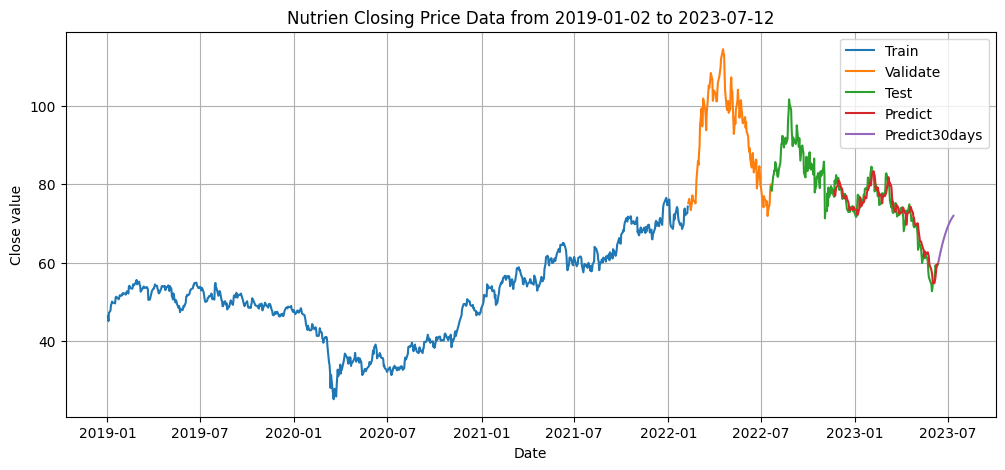

In [21]:
plt.figure(figsize=(12, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size + val_size : ], scaler.inverse_transform(test_data))

plt.plot(df.index[train_size + val_size + best_window_size + 1: ], best_y_pred)

plt.plot(index_next_30_days, scaler.inverse_transform(np.array(y_next_30_days).reshape(-1, 1)))

plt.legend(['Train', 'Validate', 'Test', 'Predict', 'Predict30days'])

plt.grid()
plt.title(f"Nutrien Closing Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.savefig('TCAN_712_NTR.png')
plt.show()